<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Explore-other-reward-functions" data-toc-modified-id="Explore-other-reward-functions-1">Explore other reward functions</a></span><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1.1">Goal</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2">Imports</a></span></li><li><span><a href="#Code" data-toc-modified-id="Code-1.3">Code</a></span><ul class="toc-item"><li><span><a href="#Data-generation" data-toc-modified-id="Data-generation-1.3.1">Data generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.3.2">Evaluation</a></span></li></ul></li><li><span><a href="#Ranking-reward-vs-random-agents" data-toc-modified-id="Ranking-reward-vs-random-agents-1.4">Ranking reward vs random agents</a></span><ul class="toc-item"><li><span><a href="#ranking_reward_-1_1" data-toc-modified-id="ranking_reward_-1_1-1.4.1">ranking_reward_-1_1</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.4.1.1">Generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.4.1.2">Evaluation</a></span></li></ul></li><li><span><a href="#ranking_reward_-1_2" data-toc-modified-id="ranking_reward_-1_2-1.4.2">ranking_reward_-1_2</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.4.2.1">Generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.4.2.2">Evaluation</a></span></li></ul></li><li><span><a href="#ranking_reward_-1_3" data-toc-modified-id="ranking_reward_-1_3-1.4.3">ranking_reward_-1_3</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.4.3.1">Generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.4.3.2">Evaluation</a></span></li></ul></li><li><span><a href="#ranking_reward_-1_4" data-toc-modified-id="ranking_reward_-1_4-1.4.4">ranking_reward_-1_4</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.4.4.1">Generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.4.4.2">Evaluation</a></span></li></ul></li><li><span><a href="#ranking_reward_-1_5" data-toc-modified-id="ranking_reward_-1_5-1.4.5">ranking_reward_-1_5</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.4.5.1">Generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.4.5.2">Evaluation</a></span></li></ul></li><li><span><a href="#ranking_reward_-2_5" data-toc-modified-id="ranking_reward_-2_5-1.4.6">ranking_reward_-2_5</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.4.6.1">Generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.4.6.2">Evaluation</a></span></li></ul></li><li><span><a href="#ranking_reward_-4_5" data-toc-modified-id="ranking_reward_-4_5-1.4.7">ranking_reward_-4_5</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.4.7.1">Generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.4.7.2">Evaluation</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.4.8">Summary</a></span></li></ul></li><li><span><a href="#Ranking-reward-vs-Greedy-agents" data-toc-modified-id="Ranking-reward-vs-Greedy-agents-1.5">Ranking reward vs Greedy agents</a></span><ul class="toc-item"><li><span><a href="#ranking_reward_-1_3" data-toc-modified-id="ranking_reward_-1_3-1.5.1">ranking_reward_-1_3</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.5.1.1">Generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.5.1.2">Evaluation</a></span></li></ul></li><li><span><a href="#ranking_reward_-2_3" data-toc-modified-id="ranking_reward_-2_3-1.5.2">ranking_reward_-2_3</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.5.2.1">Generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.5.2.2">Evaluation</a></span></li></ul></li><li><span><a href="#ranking_reward_-4_3" data-toc-modified-id="ranking_reward_-4_3-1.5.3">ranking_reward_-4_3</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.5.3.1">Generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.5.3.2">Evaluation</a></span></li></ul></li></ul></li><li><span><a href="#Ranking-reward-vs-Epsilon-greedy-agents" data-toc-modified-id="Ranking-reward-vs-Epsilon-greedy-agents-1.6">Ranking reward vs Epsilon greedy agents</a></span><ul class="toc-item"><li><span><a href="#ranking_reward_-1_3" data-toc-modified-id="ranking_reward_-1_3-1.6.1">ranking_reward_-1_3</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.6.1.1">Generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.6.1.2">Evaluation</a></span></li></ul></li><li><span><a href="#ranking_reward_-2_3" data-toc-modified-id="ranking_reward_-2_3-1.6.2">ranking_reward_-2_3</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.6.2.1">Generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.6.2.2">Evaluation</a></span></li></ul></li><li><span><a href="#ranking_reward_-4_3" data-toc-modified-id="ranking_reward_-4_3-1.6.3">ranking_reward_-4_3</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.6.3.1">Generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.6.3.2">Evaluation</a></span></li></ul></li></ul></li><li><span><a href="#Ranking-reward-vs-boilergoose" data-toc-modified-id="Ranking-reward-vs-boilergoose-1.7">Ranking reward vs boilergoose</a></span><ul class="toc-item"><li><span><a href="#ranking_reward_-2_3" data-toc-modified-id="ranking_reward_-2_3-1.7.1">ranking_reward_-2_3</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.7.1.1">Generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.7.1.2">Evaluation</a></span></li></ul></li><li><span><a href="#ranking_reward_-2_3-epsilon-0.05" data-toc-modified-id="ranking_reward_-2_3-epsilon-0.05-1.7.2">ranking_reward_-2_3 epsilon 0.05</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.7.2.1">Generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.7.2.2">Evaluation</a></span></li></ul></li><li><span><a href="#Sweep-over-epsilon" data-toc-modified-id="Sweep-over-epsilon-1.7.3">Sweep over epsilon</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.7.3.1">Generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.7.3.2">Evaluation</a></span></li></ul></li><li><span><a href="#Combine-greedy-and-non-greedy-players" data-toc-modified-id="Combine-greedy-and-non-greedy-players-1.7.4">Combine greedy and non greedy players</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.7.4.1">Generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.7.4.2">Evaluation</a></span></li><li><span><a href="#Bigger-models" data-toc-modified-id="Bigger-models-1.7.4.3">Bigger models</a></span></li></ul></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.8">Summary</a></span></li><li><span><a href="#Debug" data-toc-modified-id="Debug-1.9">Debug</a></span><ul class="toc-item"><li><span><a href="#This-works-without-any-problem-if-launched-on-the-first-place" data-toc-modified-id="This-works-without-any-problem-if-launched-on-the-first-place-1.9.1">This works without any problem if launched on the first place</a></span></li><li><span><a href="#Other-code-that-does-not-work" data-toc-modified-id="Other-code-that-does-not-work-1.9.2">Other code that does not work</a></span></li></ul></li></ul></li></ul></div>

# Explore other reward functions

## Goal

The goal of this notebooks is to continue learning about the Q value function, but trying other reward methods.

## Imports

In [4]:
# Use this to reload changes in python scripts
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
import kaggle_environments
from kaggle_environments import make
from kaggle_environments import evaluate
from kaggle_environments.envs.hungry_geese.hungry_geese import Action
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import pandas as pd
from tqdm.notebook import tqdm
import time
from itertools import permutations
from functools import partial
import gc

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
import tensorflow.keras as keras

from hungry_geese import GameState
from hungry_geese.state import make_board_egocentric, get_head_position, combine_data, horizontal_simmetry, vertical_simmetry
from hungry_geese.utils import ACTIONS, opposite_action, get_timestamp
from hungry_geese.definitions import ACTION_TO_IDX
from hungry_geese.agents import EpsilonAgent
from hungry_geese.evaluation import play_matches_in_parallel, monitor_progress
from hungry_geese.elo import EloRanking
from hungry_geese.model import simple_model, create_model_for_training

%config Completer.use_jedi = False

In [6]:
plt.plot()
plt.close('all')
plt.rcParams["figure.figsize"] = (30, 5)  
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 16

## Code

### Data generation

In [7]:
from concurrent.futures import ProcessPoolExecutor

def play_matches_in_parallel_and_save_history(agents, max_workers=20, n_matches=1000,
                                              running_on_notebook=True):
    """
    Plays n_matches in parallel using ProcessPoolExecutor

    Parameters
    -----------
    agents : dict
        Dictionary that matches name of the agents with the code
    sample_agents_func : func
        Function that returns random keys of the agents for playing a game
    """
    with ProcessPoolExecutor(max_workers=max_workers) as pool:
        matches_results = []
        submits = []
        for i in range(n_matches):
            submits.append(pool.submit(play_game, agents=agents))
        monitor_progress(submits, running_on_notebook)
        matches_results = [submit.result() for submit in submits]
    return matches_results

def play_game(agents):
    env = make("hungry_geese")
    return env.run(agents=agents)

In [8]:
def test_agent(agent):
    print('Testing agent: %s' % agent)
    env = make('hungry_geese', debug=True)
    env.run([agent]*4)

In [9]:
def create_train_data(agents, n_matches, output_file, reward_name, max_workers=18):
    """
    Creates train data without any simmetry
    """
    test_agent(agents[0])
    matches_results = play_matches_in_parallel_and_save_history(
        agents, n_matches=n_matches, max_workers=max_workers)
    
    env = make("hungry_geese")
    conf = env.configuration

    state = GameState(reward_name=reward_name)
    train_data = []

    for match in tqdm(matches_results):
        for idx in range(4):
            state.reset()
            for step_idx, step in enumerate(match):
                observation = step[0]['observation'].copy()
                observation['index'] = idx
                state.update(observation, conf)
                if step_idx:
                    state.add_action(step[idx]['action'])
                if not observation['geese'][idx]:
                    break
            train_data.append(state.prepare_data_for_training())

    train_data = combine_data(train_data)
    print('Size of the boards is %.1f GB' % (train_data[0].nbytes/1e9))
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    np.savez_compressed(output_file, boards=train_data[0], features=train_data[1], actions=train_data[2], rewards=train_data[3])

### Evaluation

In [10]:
initial_elo_ranking = pd.read_csv('../data/elo_ranking.csv', index_col='model')
initial_elo_ranking

,ranking
model,
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
straightforward_bfs,1004
greedy,981
greedyhoarder,766
random_plus,706


In [11]:
agents = {
    'random': 'random',
    'random_plus': '../forum/agents/random_plus.py',
    'greedy': 'greedy',
    'risk_averse_goose': '../forum/agents/risk_averse_goose.py',
    'goose_on_a_healthy_diet': '../forum/agents/goose_on_a_healthy_diet.py',
    'straightforward_bfs': '../forum/agents/straightforward_bfs.py',
    'boilergoose': '../forum/agents/boilergoose.py',
    'crazy_goose': '../forum/agents/crazy_goose.py',
    'besthoarder': '../forum/agents/besthoarder.py',
    'greedyhoarder': '../forum/agents/greedyhoarder.py',
    'q_value': '/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py',
}

In [12]:
def evaluate_agent(new_agent, adversary_agents, n_matches, single_agent=True, max_workers=20, run_agent_test=False):
    agent_name = list(new_agent.keys())[0]
    # I have found that for certain agents if the test is run then evaluation is frozen
    if run_agent_test: test_agent(new_agent[agent_name])
    reduced_agents_set = new_agent.copy()
    for adversary_agent in adversary_agents:
        reduced_agents_set[adversary_agent] = agents[adversary_agent]
    
    if single_agent:
        sample_agents_func = lambda: [agent_name] + np.random.choice(adversary_agents, 3).tolist()
    else:
        def sample_agents_func():
            while 1:
                sampled_agents = [agent_name] + np.random.choice(adversary_agents + [agent_name], 3).tolist()
                if len(np.unique(sampled_agents)) >=2:
                    break
            return sampled_agents

    matches_agents, matches_results = play_matches_in_parallel(reduced_agents_set, sample_agents_func, n_matches=n_matches, max_workers=max_workers)
    return matches_agents, matches_results, reduced_agents_set
    
def compute_elo_ranking(matches_agents, matches_results, reduced_agents_set, initial_agent_elo, k=8):
    agent_name = [name for name in reduced_agents_set if name not in initial_elo_ranking][0]
    initial_ranking = initial_elo_ranking.to_dict()['ranking']
    initial_ranking[agent_name] = initial_agent_elo
    initial_ranking = {key: initial_ranking[key] for key in reduced_agents_set}
    elo_ranking = EloRanking(initial_ranking, {agent_name}, k=k)
    for match_agents, match_results in zip(matches_agents, matches_results):
        elo_ranking.add_match(match_agents, match_results)
    elo_ranking.plot()
    return elo_ranking.summary()

## Ranking reward vs random agents

### ranking_reward_-1_1

#### Generation

In [14]:
n_matches = 2000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py']*4
reward_name = 'ranking_reward_-1_1'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18)

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py
Goose Collision: SOUTH
Goose Collision: EAST
Goose Collision: SOUTH


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Size of the boards is 1.2 GB


In [15]:
n_matches = 10000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py']*4
reward_name = 'ranking_reward_-1_1'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18)

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py
Goose Collision: SOUTH
Goose Collision: EAST
Goose Collision: WEST


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Size of the boards is 6.0 GB


In [8]:
n_matches = 20000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py']*4
reward_name = 'ranking_reward_-1_1'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18)

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py
Goose Collision: WEST
Goose Collision: SOUTH
Goose Starved: Action.EAST


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

Size of the boards is 11.8 GB


In [9]:
n_matches = 40000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py']*4
reward_name = 'ranking_reward_-1_1'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18)

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py
Goose Collision: EAST
Goose Collision: SOUTH
Goose Collision: SOUTH
Goose Collision: WEST


  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

Size of the boards is 23.8 GB


#### Evaluation

In [ ]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/03_baseline_40000/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False)

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
straightforward_bfs,1004
q_value_pretrained,995
greedy,981
random_plus,706


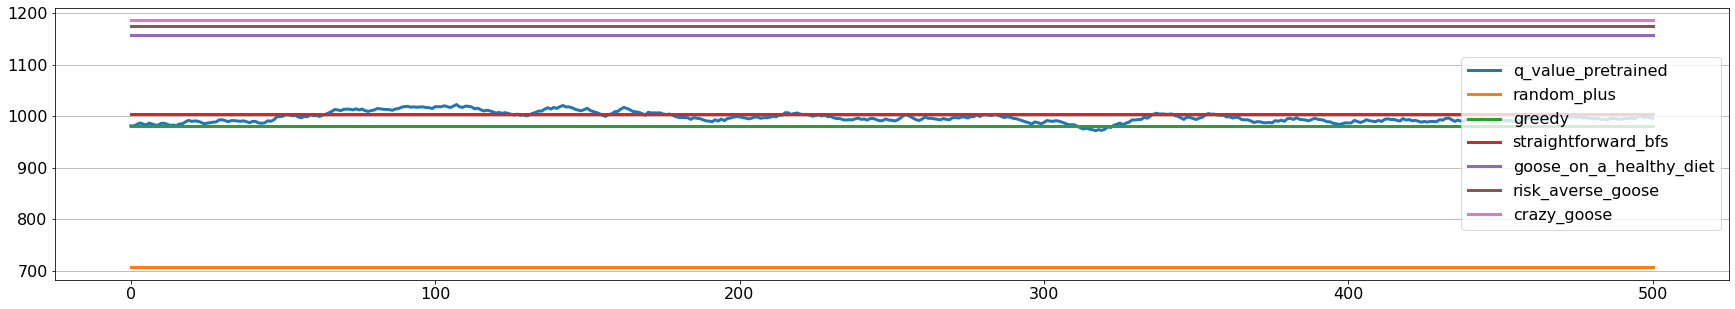

In [18]:
compute_elo_ranking(*ret, initial_agent_elo=981, k=2)

This first agent is similar to greedy, so no as good as the one we trained with previous reward.

### ranking_reward_-1_2

#### Generation

In [19]:
n_matches = 2000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py']*4
reward_name = 'ranking_reward_-1_2'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18)

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py
Goose Collision: NORTH
Goose Collision: WEST
Goose Collision: SOUTH


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Size of the boards is 1.2 GB


In [10]:
n_matches = 10000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py']*4
reward_name = 'ranking_reward_-1_2'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18)

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py
Goose Collision: NORTH
Goose Collision: EAST
Goose Collision: EAST
Goose Collision: WEST


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Size of the boards is 5.9 GB


#### Evaluation

In [15]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/04_ranking_reward_-1_2_10000episodes/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=20)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/04_ranking_reward_-1_2_10000episodes/q_value_agent.py
Goose Collision: NORTH
Goose Collision: NORTH
Body Hit: (0, <Action.NORTH: 1>, 36, [47, 58, 59, 48, 37, 36, 35, 34, 23])


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1102
straightforward_bfs,1004
greedy,981
random_plus,706


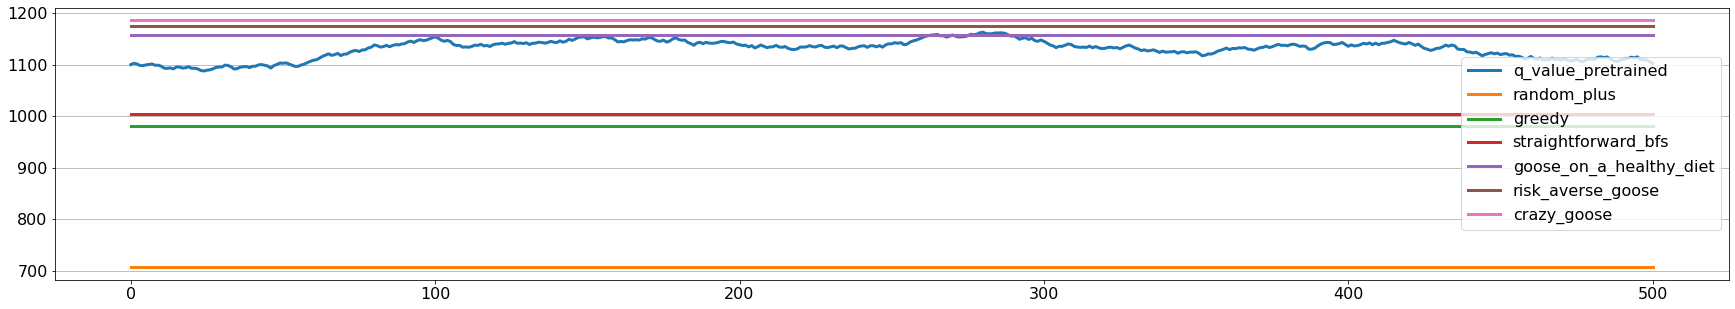

In [16]:
compute_elo_ranking(*ret, initial_agent_elo=1100, k=2)

### ranking_reward_-1_3

#### Generation

In [11]:
n_matches = 2000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py']*4
reward_name = 'ranking_reward_-1_3'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18)

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py
Goose Collision: SOUTH
Goose Collision: EAST
Goose Collision: SOUTH


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Size of the boards is 1.2 GB


In [12]:
n_matches = 10000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py']*4
reward_name = 'ranking_reward_-1_3'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18)

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py
Goose Collision: SOUTH
Goose Collision: NORTH
Goose Collision: WEST
Goose Collision: EAST


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Size of the boards is 5.9 GB


#### Evaluation

In [17]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/05_ranking_reward_-1_3_10000episodes/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=20)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/05_ranking_reward_-1_3_10000episodes/q_value_agent.py
Goose Collision: WEST
Goose Collision: EAST


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1109
straightforward_bfs,1004
greedy,981
random_plus,706


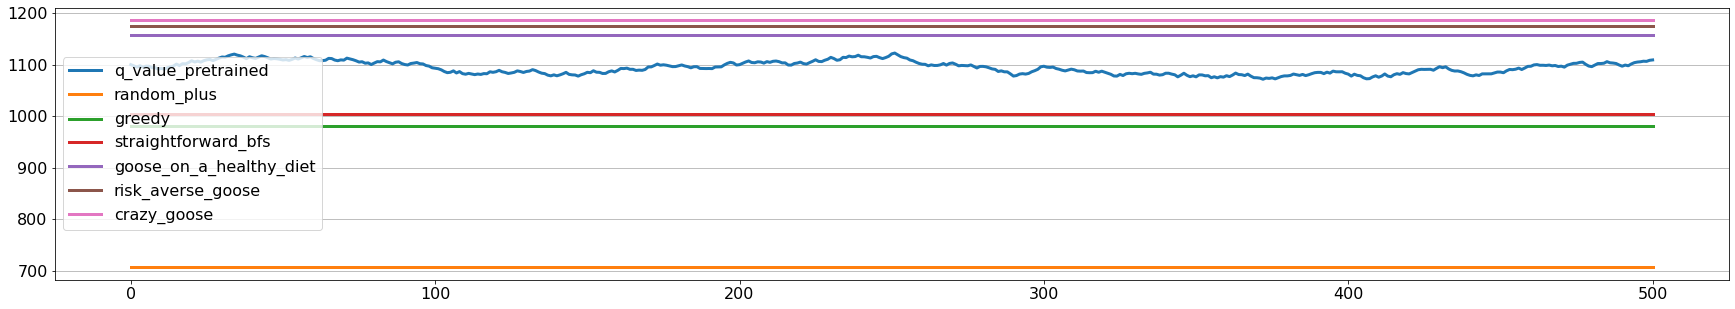

In [18]:
compute_elo_ranking(*ret, initial_agent_elo=1100, k=2)

### ranking_reward_-1_4

#### Generation

In [10]:
n_matches = 2000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py']*4
reward_name = 'ranking_reward_-1_4'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18)

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py
Goose Collision: SOUTH
Goose Starved: Action.WEST
Goose Collision: NORTH
Goose Collision: SOUTH


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Size of the boards is 1.2 GB


In [11]:
n_matches = 10000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py']*4
reward_name = 'ranking_reward_-1_4'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18)

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py
Goose Collision: NORTH
Goose Collision: NORTH
Goose Starved: Action.NORTH


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Size of the boards is 5.9 GB


#### Evaluation

In [16]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/06_ranking_reward_-1_4_10000episodes/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=20)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/06_ranking_reward_-1_4_10000episodes/q_value_agent.py
Goose Collision: SOUTH
Body Hit: (0, <Action.NORTH: 1>, 48, [59, 70, 4, 15, 26, 37, 48, 47, 36, 25])


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1071
straightforward_bfs,1004
greedy,981
random_plus,706


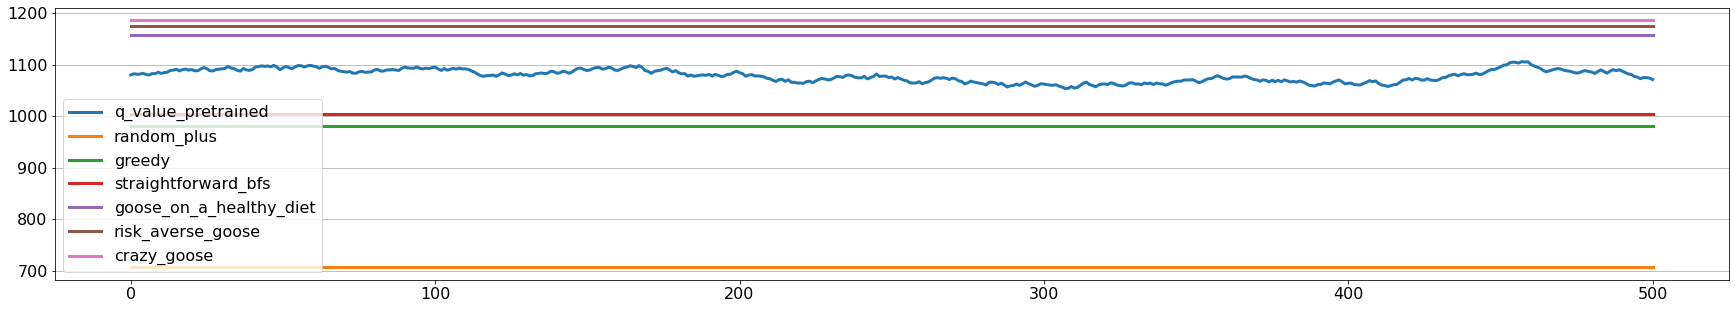

In [18]:
compute_elo_ranking(*ret, initial_agent_elo=1080, k=2)

Let's compare against an agent with more parameters. (32 filters on convolutional encoder)

In [19]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/08_ranking_reward_-1_4_10000episodes_encoder_x32/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=20)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/08_ranking_reward_-1_4_10000episodes_encoder_x32/q_value_agent.py
Goose Collision: SOUTH
Goose Collision: EAST
Body Hit: (2, <Action.NORTH: 1>, 72, [6, 17, 28, 39, 50, 61, 72])


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
straightforward_bfs,1004
q_value_pretrained,1002
greedy,981
random_plus,706


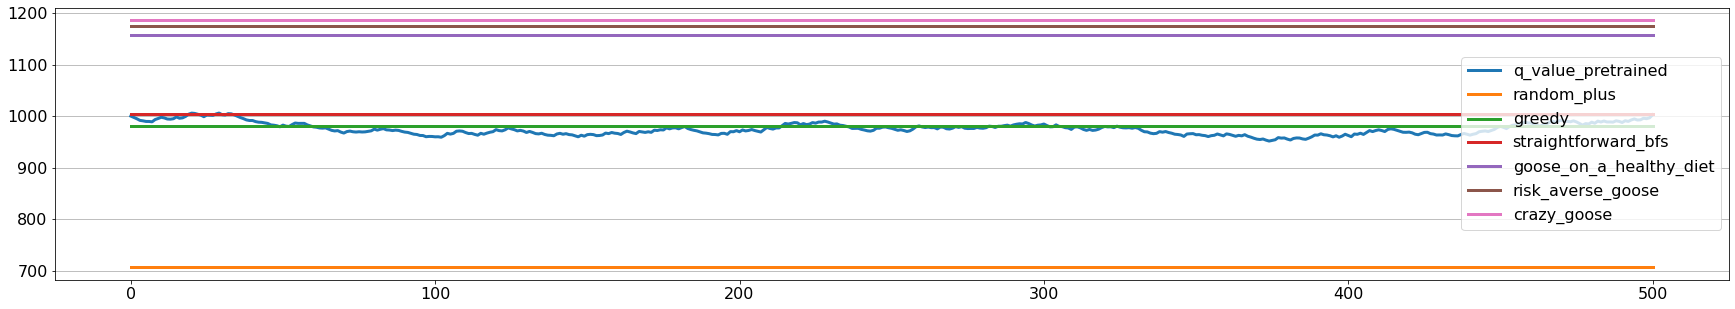

In [21]:
compute_elo_ranking(*ret, initial_agent_elo=1000, k=2)

Worse score, sign of overfitting. Maybe we should try to decrease capacity then.

### ranking_reward_-1_5

#### Generation

In [12]:
n_matches = 2000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py']*4
reward_name = 'ranking_reward_-1_5'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18)

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py
Goose Collision: NORTH
Goose Collision: SOUTH
Goose Collision: EAST


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Size of the boards is 1.2 GB


In [13]:
n_matches = 10000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py']*4
reward_name = 'ranking_reward_-1_5'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18)

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py
Goose Collision: EAST
Goose Collision: SOUTH
Goose Collision: NORTH


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Size of the boards is 6.0 GB


#### Evaluation

In [10]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/07_ranking_reward_-1_5_10000episodes/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=20)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/07_ranking_reward_-1_5_10000episodes/q_value_agent.py
Goose Collision: EAST
Goose Collision: EAST
Body Hit: (2, <Action.SOUTH: 3>, 7, [73, 62, 51, 40, 29, 18, 7, 8, 74, 63])


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
straightforward_bfs,1004
q_value_pretrained,994
greedy,981
random_plus,706


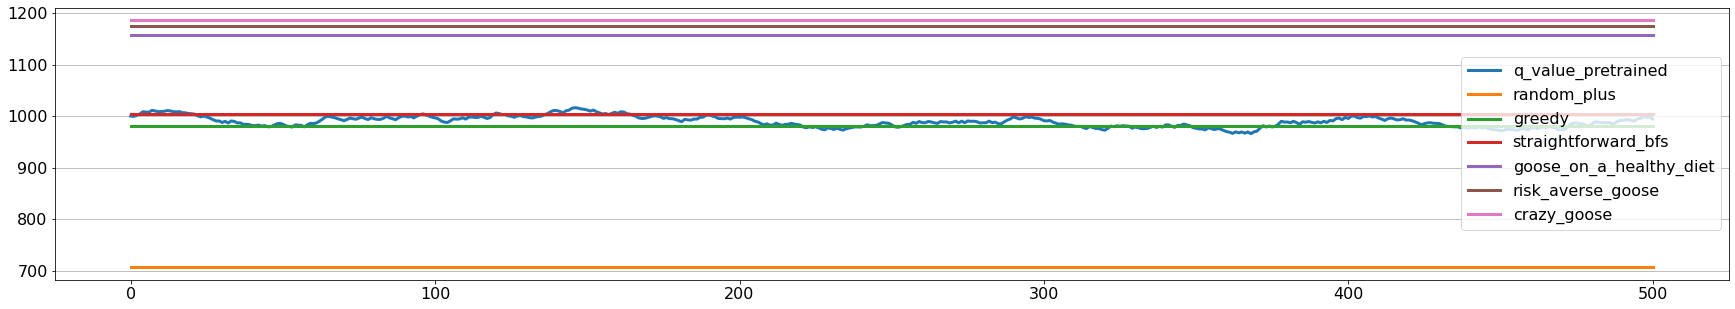

In [11]:
compute_elo_ranking(*ret, initial_agent_elo=1000, k=2)

### ranking_reward_-2_5

#### Generation

In [22]:
n_matches = 2000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py']*4
reward_name = 'ranking_reward_-2_5'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18)

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py
Goose Collision: EAST
Goose Collision: NORTH
Goose Starved: Action.WEST


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Size of the boards is 1.2 GB


In [23]:
n_matches = 10000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py']*4
reward_name = 'ranking_reward_-2_5'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18)

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py
Goose Collision: NORTH
Goose Collision: WEST
Goose Collision: WEST


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Size of the boards is 5.9 GB


#### Evaluation

In [12]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/09_ranking_reward_-2_5_10000episodes/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=20)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/09_ranking_reward_-2_5_10000episodes/q_value_agent.py
Goose Collision: SOUTH
Goose Collision: EAST


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1105
straightforward_bfs,1004
greedy,981
random_plus,706


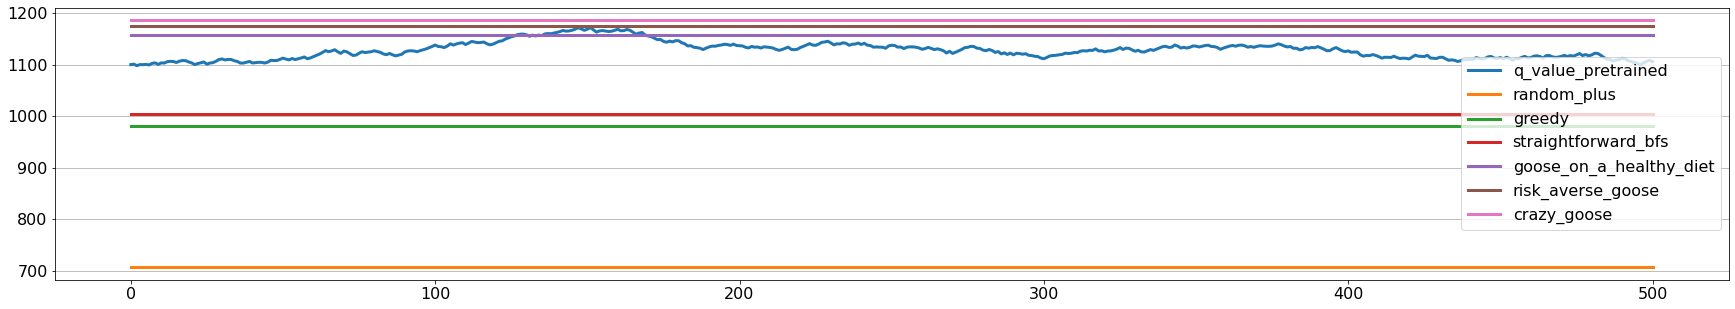

In [14]:
compute_elo_ranking(*ret, initial_agent_elo=1100, k=2)

### ranking_reward_-4_5

#### Generation

In [24]:
n_matches = 2000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py']*4
reward_name = 'ranking_reward_-4_5'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18)

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py
Goose Collision: NORTH
Goose Collision: SOUTH
Goose Starved: Action.WEST
Goose Starved: Action.NORTH


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Size of the boards is 1.2 GB


In [25]:
n_matches = 10000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py']*4
reward_name = 'ranking_reward_-4_5'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18)

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py
Goose Collision: EAST
Goose Collision: WEST
Goose Starved: Action.EAST


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Size of the boards is 6.0 GB


In [22]:
n_matches = 80000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py']*4
reward_name = 'ranking_reward_-4_5'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18)

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py
Goose Collision: NORTH
Goose Collision: SOUTH
Goose Starved: Action.EAST
Goose Starved: Action.EAST


  0%|          | 0/80000 [00:00<?, ?it/s]

  0%|          | 0/80000 [00:00<?, ?it/s]

Size of the boards is 47.3 GB


#### Evaluation

In [15]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/10_ranking_reward_-4_5_10000episodes/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=20)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/10_ranking_reward_-4_5_10000episodes/q_value_agent.py


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1138
straightforward_bfs,1004
greedy,981
random_plus,706


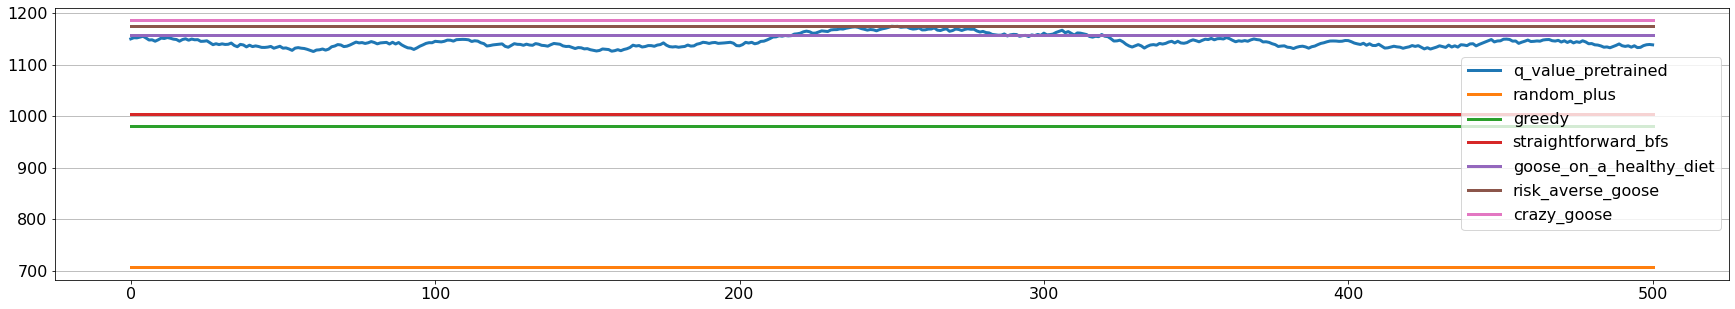

In [18]:
compute_elo_ranking(*ret, initial_agent_elo=1150, k=2)

Let's compare it againts a player trained with 80k episodes.

In [10]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/11_ranking_reward_-4_5_80000episodes/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=20)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/11_ranking_reward_-4_5_80000episodes/q_value_agent.py
Goose Collision: WEST
Body Hit: (0, <Action.NORTH: 1>, 39, [50, 49, 38, 39, 28, 29, 18])


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1116
straightforward_bfs,1004
greedy,981
random_plus,706


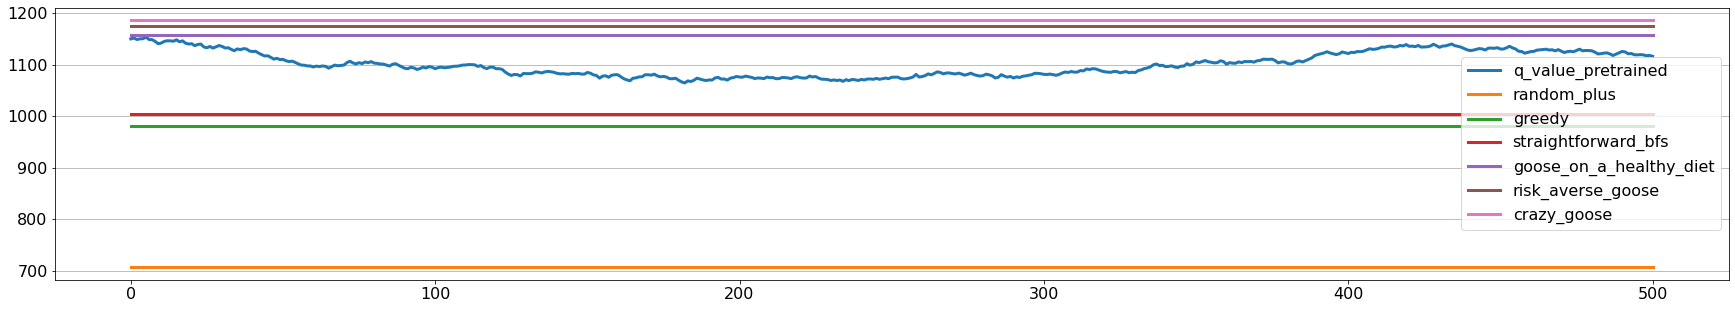

In [11]:
compute_elo_ranking(*ret, initial_agent_elo=1150, k=2)

Let's remove random agent.

In [12]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/11_ranking_reward_-4_5_80000episodes/q_value_agent.py'},
    ['greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=20)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/11_ranking_reward_-4_5_80000episodes/q_value_agent.py
Goose Collision: SOUTH
Goose Collision: WEST


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1091
straightforward_bfs,1004
greedy,981


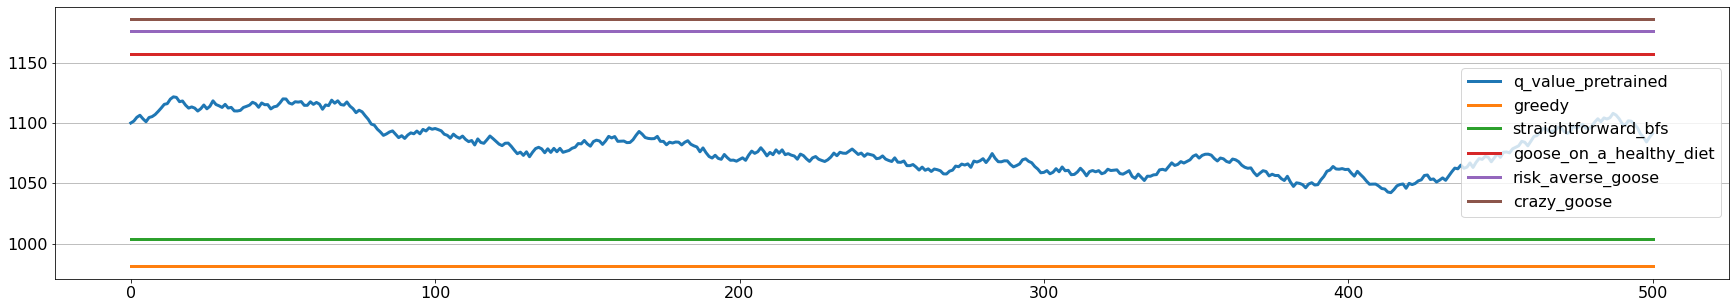

In [14]:
compute_elo_ranking(*ret, initial_agent_elo=1100, k=2)

I have also trained a model with reduce learning rate on plateau. Training loss is very similar.

However as seen below it is much better.

In [10]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/12_ranking_reward_-4_5_80000episodes_reduce_lr_on_plateau/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=20)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/12_ranking_reward_-4_5_80000episodes_reduce_lr_on_plateau/q_value_agent.py
Goose Collision: EAST


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
q_value_pretrained,1230
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
straightforward_bfs,1004
greedy,981
random_plus,706


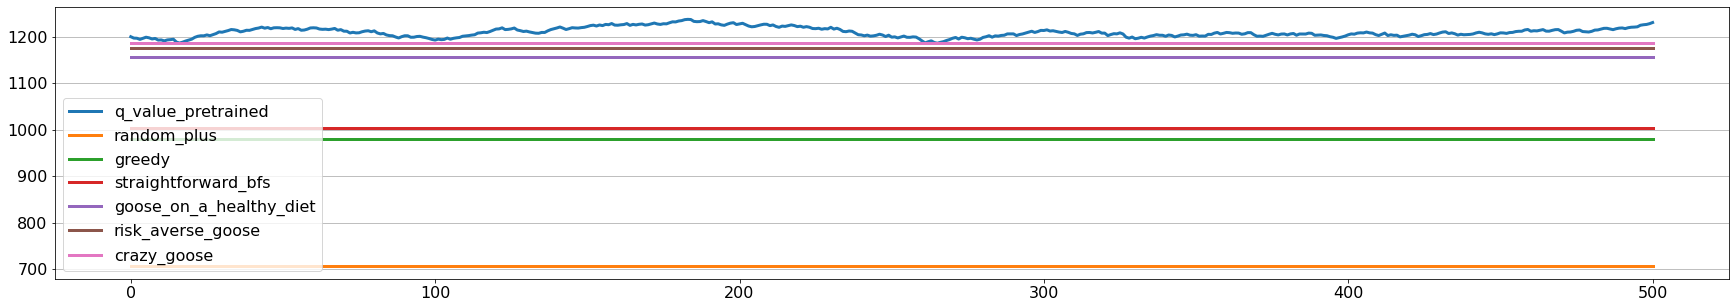

In [12]:
compute_elo_ranking(*ret, initial_agent_elo=1200, k=2)

In [15]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/12_ranking_reward_-4_5_80000episodes_reduce_lr_on_plateau/q_value_agent.py'},
    ['greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=20)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/12_ranking_reward_-4_5_80000episodes_reduce_lr_on_plateau/q_value_agent.py
Goose Collision: EAST


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
q_value_pretrained,1206
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
straightforward_bfs,1004
greedy,981


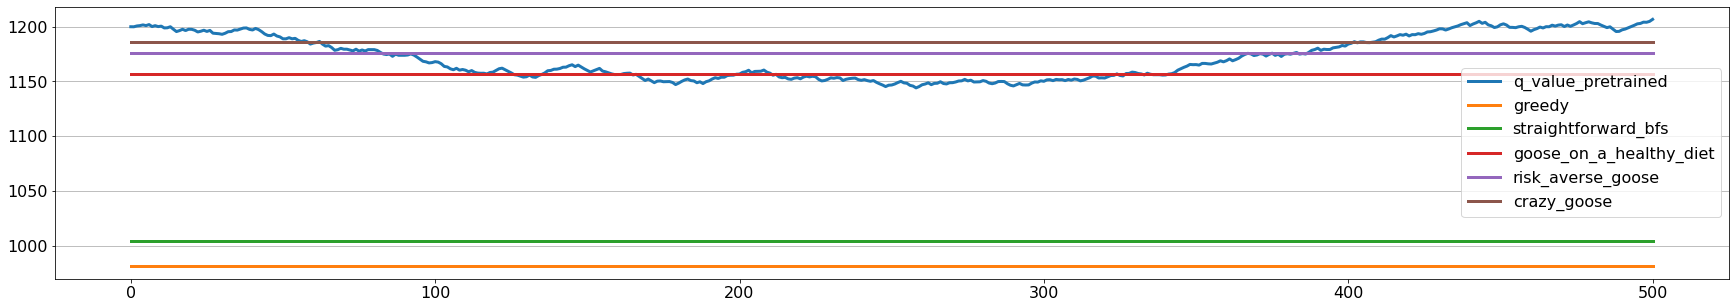

In [17]:
compute_elo_ranking(*ret, initial_agent_elo=1200, k=1)

In [18]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/12_ranking_reward_-4_5_80000episodes_reduce_lr_on_plateau/q_value_agent.py'},
    ['goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=20)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/12_ranking_reward_-4_5_80000episodes_reduce_lr_on_plateau/q_value_agent.py


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
q_value_pretrained,1202
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157


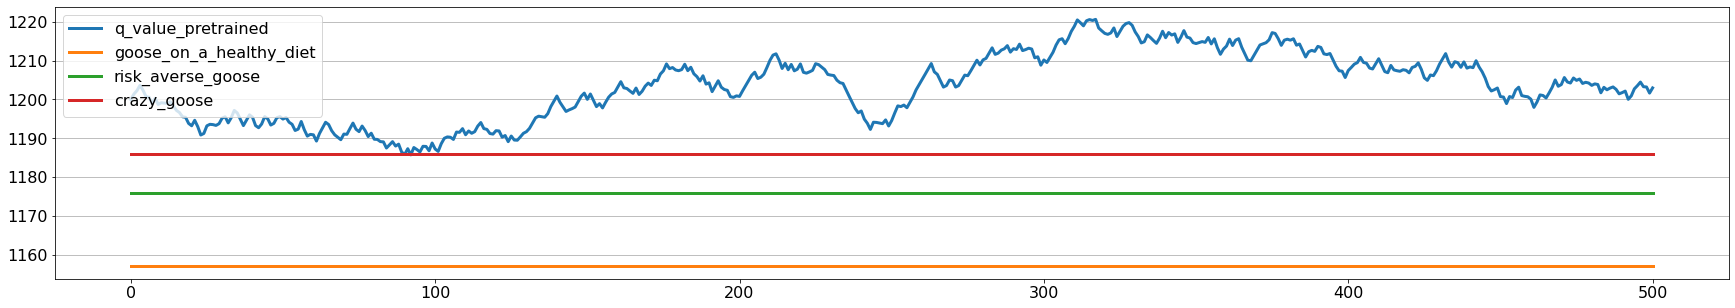

In [19]:
compute_elo_ranking(*ret, initial_agent_elo=1200, k=1)

In [21]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/12_ranking_reward_-4_5_80000episodes_reduce_lr_on_plateau/q_value_agent.py'},
    ['goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose', 'besthoarder', 'boilergoose'],
    n_matches=500, single_agent=False, max_workers=20)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/10_q_value_pretrain_ranking_reward_random/12_ranking_reward_-4_5_80000episodes_reduce_lr_on_plateau/q_value_agent.py


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1103


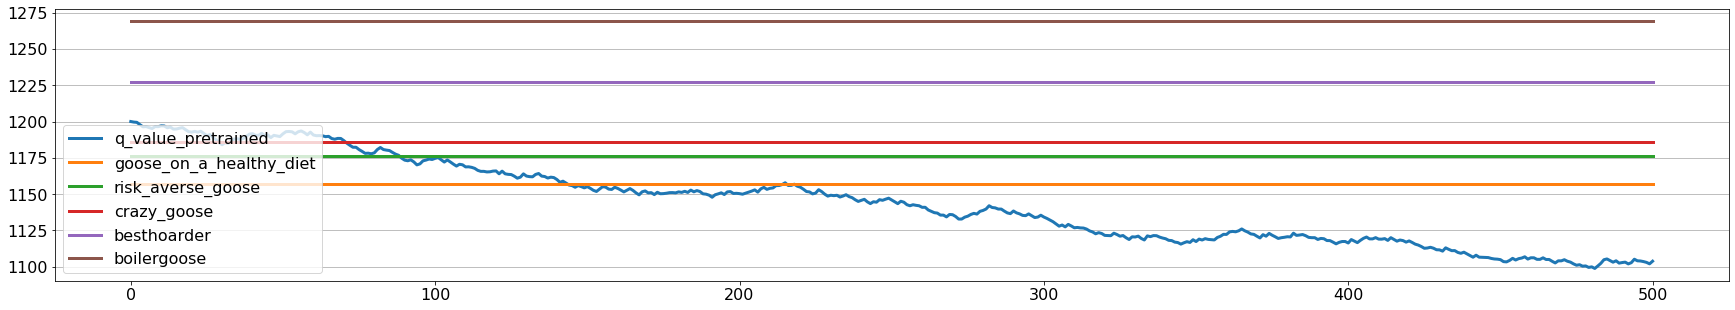

In [22]:
compute_elo_ranking(*ret, initial_agent_elo=1200, k=1)

### Summary

| model                                                     | elo score | validation loss |
|-----------------------------------------------------------|-----------|-----------------|
| Baseline_sparse_reward_80000                              | 1140      | ~1.3            |
| 03_ranking_reward_-1_1_40000                              | 995       | 0.13            |
| 04_ranking_reward_-1_2_10000episodes                      | 1102      | 0.18            |
| 05_ranking_reward_-1_3_10000episodes                      | 1109      | 0.20            |
| 06_ranking_reward_-1_4_10000episodes                      | 1071      | 0.23            |
| 08_ranking_reward_-1_4_10000episodes_encoder_x32          | 1002      | 0.28            |
| 07_ranking_reward_-1_5_10000episodes                      | 992       | 0.25            |
| 09_ranking_reward_-2_5_10000episodes                      | 1102      | 0.39            |
| 10_ranking_reward_-4_5_10000episodes                      | 1138      | 0.79            |
| 11_ranking_reward_-4_5_80000episodes                      | 1116      | 0.751           |
| 12_ranking_reward_-4_5_80000episodes_reduce_lr_on_plateau | 1230      | 0.747           |

- The loss of the new reward function is much smaller compared to sparse reward baseline, the direct comparison is 1.3 vs 0.13
- Clearly using only 1 step lookahead is not optimal
- The number of steps looakhead and the dead reward is related, as shown by the experiments with 5 steps.
- The bigger the lookahead steps the more complex the function as shown by the validation loss
- The model with reduce lr on plateau achieves the best elo score, although training loss is similar

## Ranking reward vs Greedy agents

I should be able to learn from greedy or epsilon-greedy episodes and perform better.

### ranking_reward_-1_3

#### Generation

In [23]:
n_matches = 2000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/greedy.py']*4
reward_name = 'ranking_reward_-1_3'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18)

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/greedy.py
Goose Collision: EAST
Goose Collision: EAST
Goose Collision: EAST


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Size of the boards is 3.1 GB


In [24]:
n_matches = 10000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/greedy.py']*4
reward_name = 'ranking_reward_-1_3'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18)

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/greedy.py
Body Hit: (3, <Action.WEST: 4>, 14, [15, 26, 25, 14])
Body Hit: (1, <Action.SOUTH: 3>, 11, [0, 10, 21, 11, 12])
Body Hit: (0, <Action.WEST: 4>, 34, [35, 24, 13, 12, 23, 34, 45, 46, 47, 36, 25, 14])


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Size of the boards is 15.4 GB


#### Evaluation

In [10]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/11_q_value_pretrain_ranking_reward_greedy/01_ranking_reward_-1_3_10000episodes/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=10)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/11_q_value_pretrain_ranking_reward_greedy/01_ranking_reward_-1_3_10000episodes/q_value_agent.py
Goose Collision: NORTH
Goose Collision: SOUTH
Body Hit: (0, <Action.WEST: 4>, 22, [23, 24, 13, 2, 3, 14, 25, 36, 47, 46, 45, 44, 33, 22, 11, 21])


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1023
straightforward_bfs,1004
greedy,981
random_plus,706


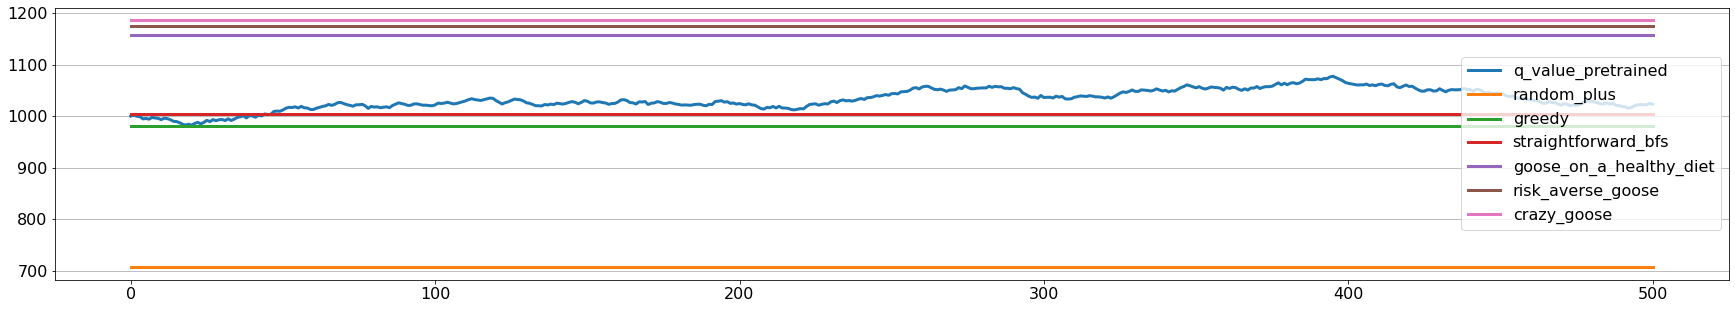

In [12]:
compute_elo_ranking(*ret, initial_agent_elo=1000, k=2)

### ranking_reward_-2_3

#### Generation

In [10]:
n_matches = 2000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/greedy.py']*4
reward_name = 'ranking_reward_-2_3'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18); gc.collect()

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/greedy.py
Goose Collision: NORTH
Goose Collision: SOUTH
Body Hit: (1, <Action.WEST: 4>, 54, [44, 33, 34, 45, 56, 55, 66, 76, 65, 54, 43, 32, 22, 11, 12, 13, 14])


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Size of the boards is 3.1 GB


In [13]:
n_matches = 10000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/greedy.py']*4
reward_name = 'ranking_reward_-2_3'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18); gc.collect()

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/greedy.py
Goose Collision: WEST
Goose Collision: WEST
Goose Collision: WEST


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Size of the boards is 15.4 GB


0

#### Evaluation

In [20]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/11_q_value_pretrain_ranking_reward_greedy/02_ranking_reward_-2_3_10000episodes/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=10)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/11_q_value_pretrain_ranking_reward_greedy/02_ranking_reward_-2_3_10000episodes/q_value_agent.py
Goose Collision: EAST
Goose Collision: WEST


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1083
straightforward_bfs,1004
greedy,981
random_plus,706


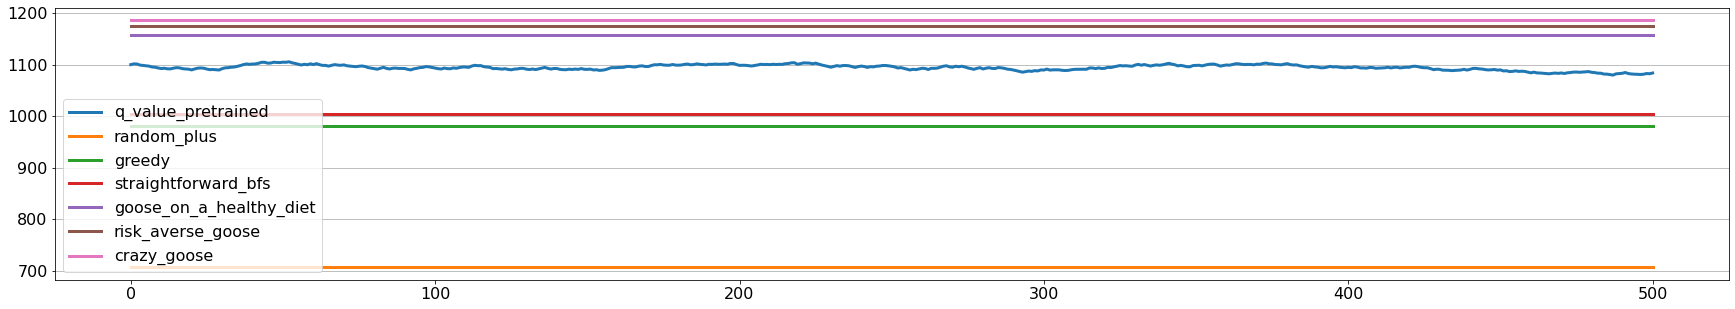

In [25]:
compute_elo_ranking(*ret, initial_agent_elo=1100, k=1)

### ranking_reward_-4_3

#### Generation

In [14]:
n_matches = 2000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/greedy.py']*4
reward_name = 'ranking_reward_-4_3'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18); gc.collect()

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/greedy.py
Goose Collision: WEST
Goose Collision: WEST
Body Hit: (3, <Action.WEST: 4>, 62, [63, 74, 73, 62, 61, 50, 49, 60, 71])


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Size of the boards is 3.1 GB


60

In [15]:
n_matches = 10000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/greedy.py']*4
reward_name = 'ranking_reward_-4_3'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18); gc.collect()

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/greedy.py
Goose Collision: NORTH
Goose Collision: EAST
Goose Collision: SOUTH


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Size of the boards is 15.4 GB


0

#### Evaluation

In [26]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/11_q_value_pretrain_ranking_reward_greedy/03_ranking_reward_-4_3_10000episodes/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=10)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/11_q_value_pretrain_ranking_reward_greedy/03_ranking_reward_-4_3_10000episodes/q_value_agent.py
Goose Collision: WEST
Body Hit: (0, <Action.SOUTH: 3>, 64, [53, 42, 31, 20, 9, 75, 64, 63, 52, 41])


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1068
straightforward_bfs,1004
greedy,981
random_plus,706


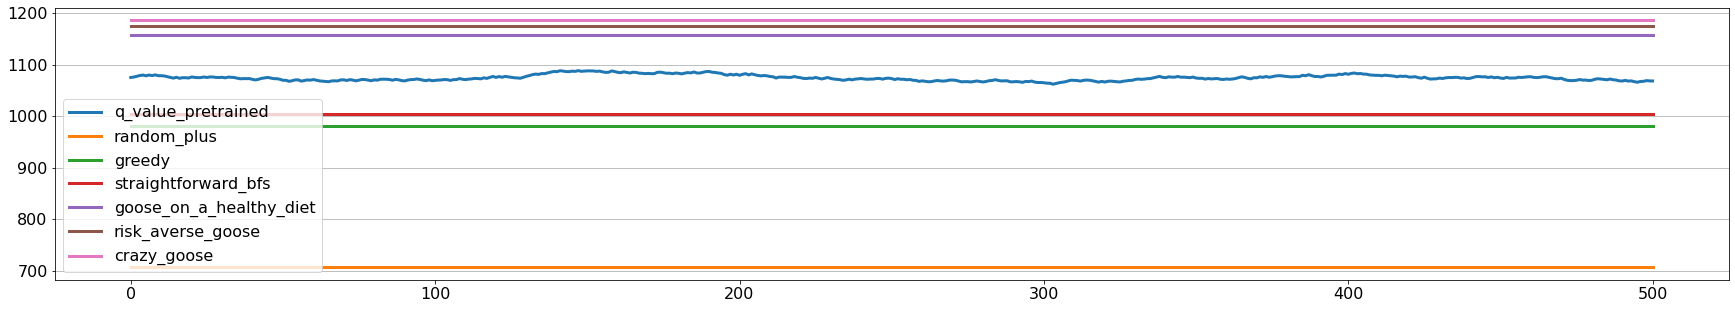

In [29]:
compute_elo_ranking(*ret, initial_agent_elo=1075, k=1)

## Ranking reward vs Epsilon greedy agents

### ranking_reward_-1_3

#### Generation

In [16]:
n_matches = 2000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_greedy_005.py']*4
reward_name = 'ranking_reward_-1_3'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18); gc.collect()

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_greedy_005.py
Goose Collision: WEST
Goose Collision: NORTH
Goose Collision: EAST


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Size of the boards is 2.4 GB


56

In [17]:
n_matches = 10000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_greedy_005.py']*4
reward_name = 'ranking_reward_-1_3'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18); gc.collect()

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_greedy_005.py
Goose Collision: SOUTH
Goose Collision: SOUTH
Body Hit: (1, <Action.SOUTH: 3>, 49, [38, 27, 26, 37, 48, 49, 50, 39, 28, 29, 18, 7])


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Size of the boards is 12.2 GB


0

#### Evaluation

In [13]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/12_q_value_pretrain_ranking_reward_epsilon_greedy_005/01_ranking_reward_-1_3_10000episodes/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=10)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/12_q_value_pretrain_ranking_reward_epsilon_greedy_005/01_ranking_reward_-1_3_10000episodes/q_value_agent.py
Goose Collision: SOUTH
Goose Collision: EAST
Body Hit: (1, <Action.NORTH: 1>, 37, [48, 47, 58, 59, 60, 49, 38, 37, 36, 35, 46, 57, 68, 69, 70, 4])


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1121
straightforward_bfs,1004
greedy,981
random_plus,706


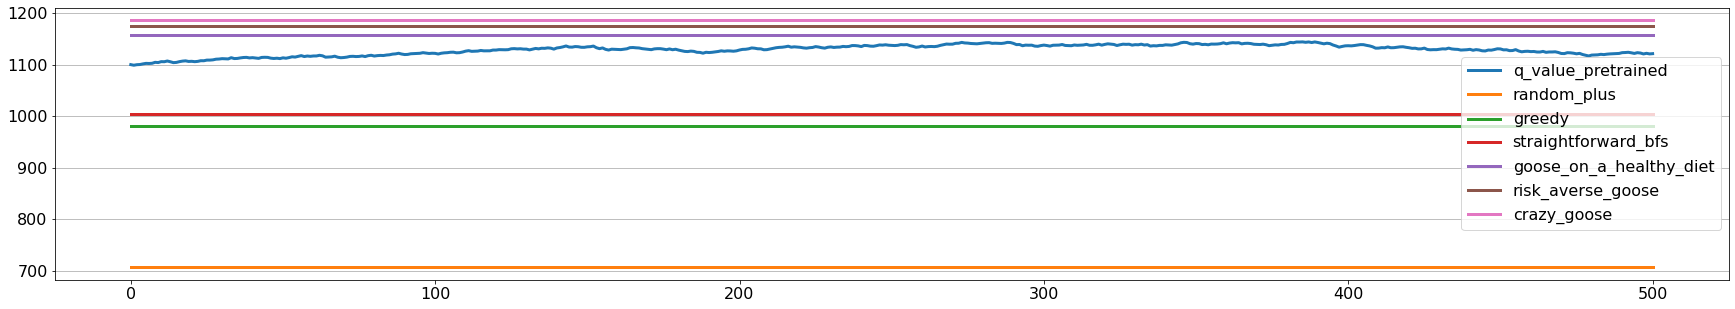

In [15]:
compute_elo_ranking(*ret, initial_agent_elo=1100, k=1)

### ranking_reward_-2_3

#### Generation

In [18]:
n_matches = 2000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_greedy_005.py']*4
reward_name = 'ranking_reward_-2_3'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18); gc.collect()

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_greedy_005.py
Body Hit: (2, <Action.SOUTH: 3>, 41, [30, 29, 28, 39, 40, 41, 52, 63])
Goose Collision: EAST
Body Hit: (0, <Action.WEST: 4>, 30, [31, 20, 19, 30, 41, 42, 43, 32, 21, 11, 22, 33])


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Size of the boards is 2.4 GB


68

In [19]:
n_matches = 10000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_greedy_005.py']*4
reward_name = 'ranking_reward_-2_3'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18); gc.collect()

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_greedy_005.py
Body Hit: (0, <Action.EAST: 2>, 41, [40, 51, 62, 63, 52, 41, 30])
Goose Collision: WEST
Body Hit: (3, <Action.EAST: 2>, 27, [26, 37, 36, 25, 14, 15, 16, 27, 38, 49, 60, 61, 50, 51, 40, 41, 52, 63])


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Size of the boards is 12.2 GB


56

#### Evaluation

In [16]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/12_q_value_pretrain_ranking_reward_epsilon_greedy_005/02_ranking_reward_-2_3_10000episodes/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=10)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/12_q_value_pretrain_ranking_reward_epsilon_greedy_005/02_ranking_reward_-2_3_10000episodes/q_value_agent.py
Goose Collision: SOUTH
Goose Collision: SOUTH


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1095
straightforward_bfs,1004
greedy,981
random_plus,706


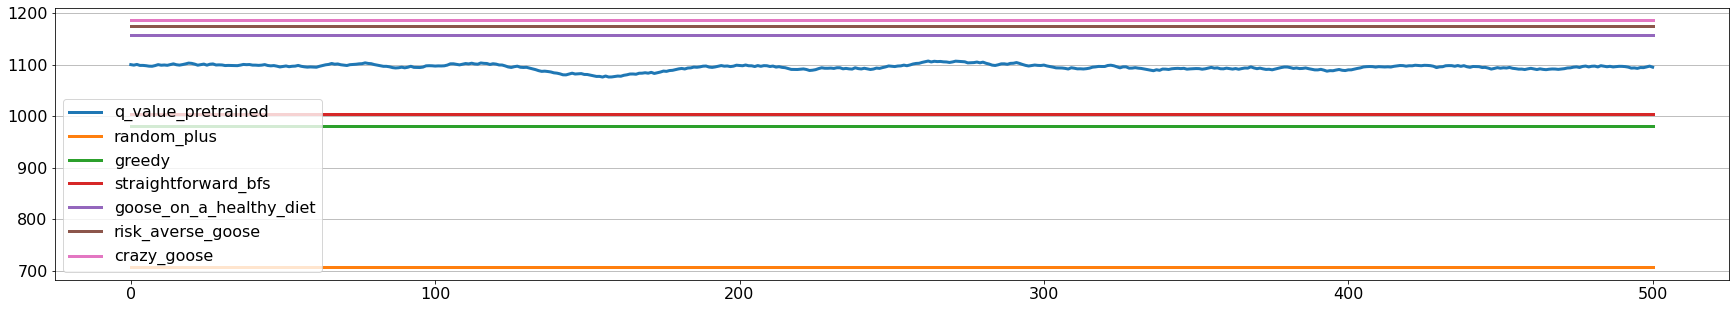

In [17]:
compute_elo_ranking(*ret, initial_agent_elo=1100, k=1)

### ranking_reward_-4_3

#### Generation

In [20]:
n_matches = 2000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_greedy_005.py']*4
reward_name = 'ranking_reward_-4_3'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18); gc.collect()

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_greedy_005.py
Body Hit: (0, <Action.SOUTH: 3>, 17, [6, 7, 18, 17, 16, 27])
Goose Collision: NORTH
Goose Collision: NORTH


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Size of the boards is 2.4 GB


56

In [21]:
n_matches = 10000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_greedy_005.py']*4
reward_name = 'ranking_reward_-4_3'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18); gc.collect()

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_greedy_005.py
Goose Collision: NORTH
Body Hit: (1, <Action.EAST: 2>, 49, [48, 37, 38, 49, 60, 71, 70])
Body Hit: (3, <Action.SOUTH: 3>, 28, [17, 6, 7, 18, 29, 28, 39, 50, 49, 38, 27, 16])


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Size of the boards is 12.2 GB


56

#### Evaluation

In [18]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/12_q_value_pretrain_ranking_reward_epsilon_greedy_005/03_ranking_reward_-4_3_10000episodes/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=10)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/12_q_value_pretrain_ranking_reward_epsilon_greedy_005/03_ranking_reward_-4_3_10000episodes/q_value_agent.py
Goose Collision: WEST


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1087
straightforward_bfs,1004
greedy,981
random_plus,706


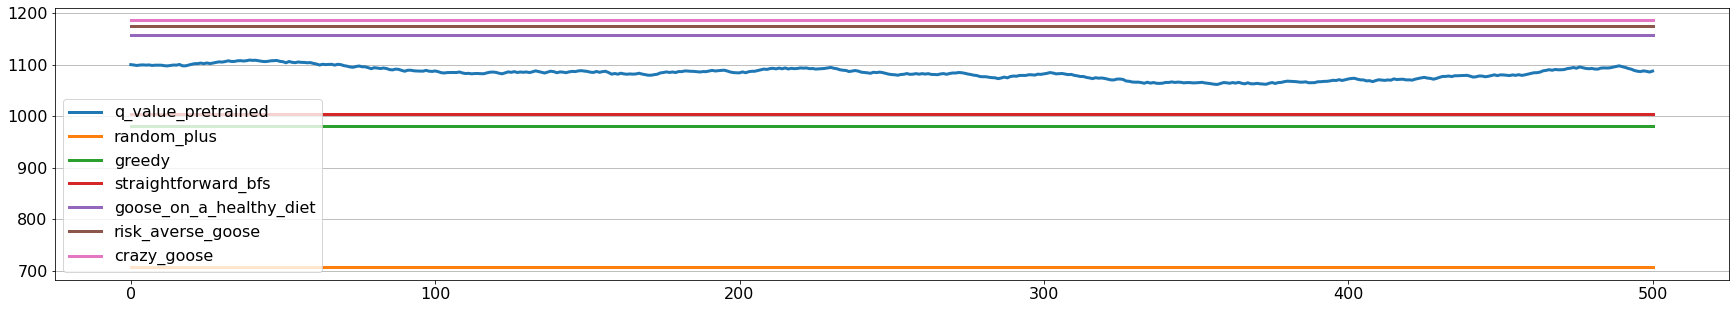

In [19]:
compute_elo_ranking(*ret, initial_agent_elo=1100, k=1)

## Ranking reward vs boilergoose

We have been succesfull when training with greedy agents, let's try with the most advanced agent we have.

### ranking_reward_-2_3

#### Generation

In [30]:
n_matches = 2000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/boilergoose.py']*4
reward_name = 'ranking_reward_-2_3'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18); gc.collect()

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/boilergoose.py
Goose Collision: NORTH


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Size of the boards is 6.3 GB


0

In [31]:
n_matches = 10000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/boilergoose.py']*4
reward_name = 'ranking_reward_-2_3'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18); gc.collect()

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/boilergoose.py
Goose Collision: WEST


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Size of the boards is 31.4 GB


0

#### Evaluation

In [10]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/13_q_value_pretrain_ranking_reward_boilergoose/01_ranking_reward_-2_3_10000episodes/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=20)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/13_q_value_pretrain_ranking_reward_boilergoose/01_ranking_reward_-2_3_10000episodes/q_value_agent.py
Goose Collision: NORTH
Goose Collision: WEST
Body Hit: (0, <Action.SOUTH: 3>, 65, [54, 53, 64, 65, 55, 44, 33])


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
straightforward_bfs,1004
greedy,981
q_value_pretrained,744
random_plus,706


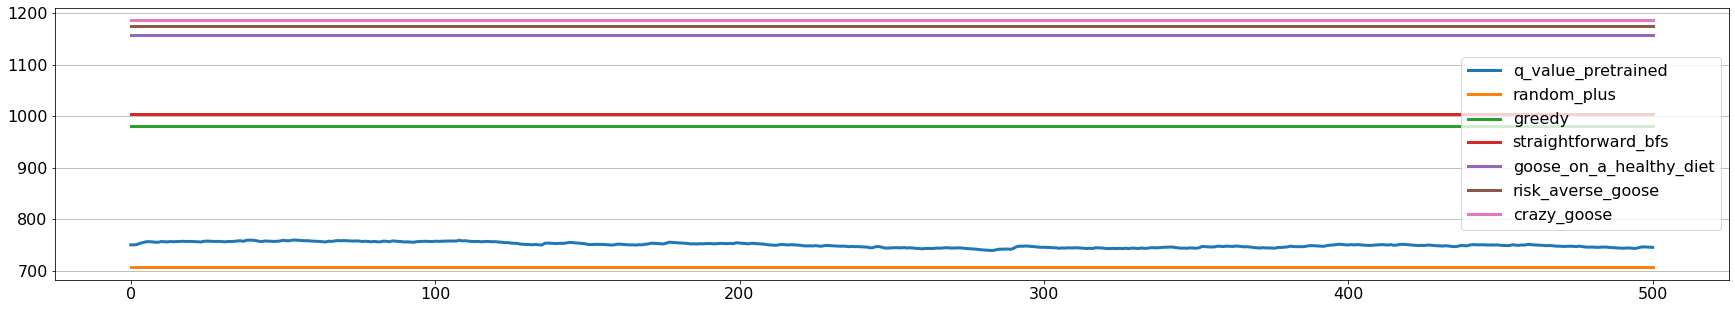

In [14]:
compute_elo_ranking(*ret, initial_agent_elo=750, k=1)

In [15]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/13_q_value_pretrain_ranking_reward_boilergoose/01_ranking_reward_-2_3_10000episodes/q_value_agent.py'},
    ['boilergoose'],
    n_matches=500, single_agent=False, max_workers=20)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/13_q_value_pretrain_ranking_reward_boilergoose/01_ranking_reward_-2_3_10000episodes/q_value_agent.py
Goose Collision: NORTH
Goose Collision: WEST
Goose Collision: EAST


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
boilergoose,1269
q_value_pretrained,902


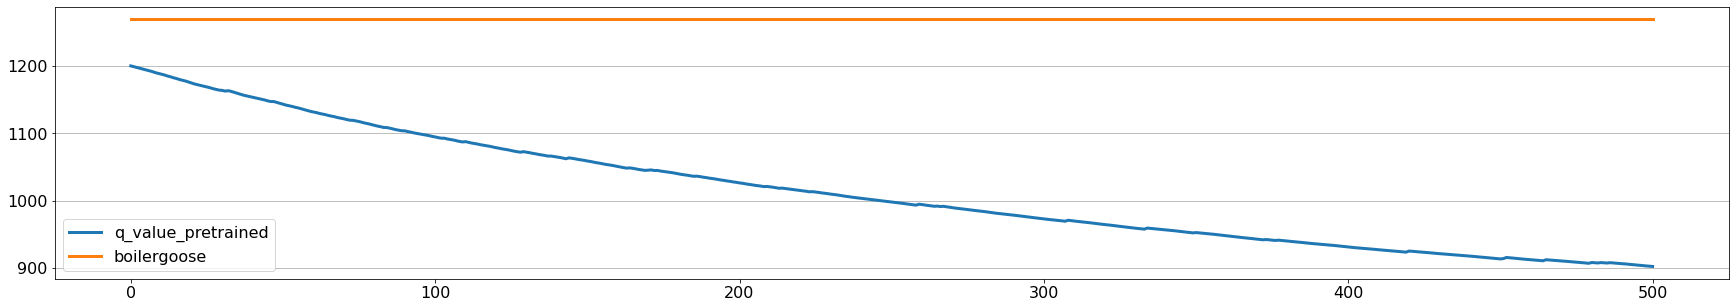

In [16]:
compute_elo_ranking(*ret, initial_agent_elo=1200, k=1)

Very bad results.

My hypothesis is that the state space was not fully explored and thus the model has not correctly learned the q value function.

### ranking_reward_-2_3 epsilon 0.05

#### Generation

In [18]:
n_matches = 2000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_boilergoose_005.py']*4
reward_name = 'ranking_reward_-2_3'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18); gc.collect()

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_boilergoose_005.py
Goose Collision: WEST
Goose Collision: EAST
Body Hit: (2, <Action.EAST: 2>, 4, [3, 2, 13, 14, 15, 4, 70])


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Size of the boards is 3.8 GB


0

In [19]:
n_matches = 10000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_boilergoose_005.py']*4
reward_name = 'ranking_reward_-2_3'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18); gc.collect()

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_boilergoose_005.py
Goose Collision: SOUTH
Goose Collision: SOUTH


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Size of the boards is 19.2 GB


0

#### Evaluation

In [11]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/13_q_value_pretrain_ranking_reward_boilergoose/02_ranking_reward_-2_3_10000episodes_epsilon005/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=20)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/13_q_value_pretrain_ranking_reward_boilergoose/02_ranking_reward_-2_3_10000episodes_epsilon005/q_value_agent.py
Goose Collision: NORTH
Goose Collision: WEST
Goose Collision: NORTH
Goose Collision: SOUTH


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1021
straightforward_bfs,1004
greedy,981
random_plus,706


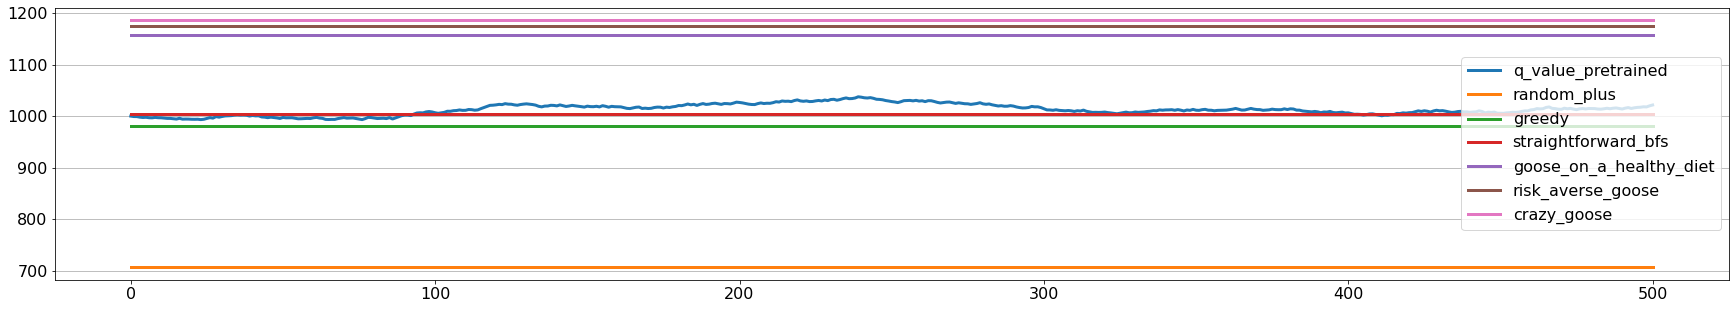

In [13]:
compute_elo_ranking(*ret, initial_agent_elo=1000, k=1)

The score is much better, but not good enough.

So we have a problem here between exploration and explotation. I need to find a better way of improving a policy. Let's try to do a sweep over epsilon.

### Sweep over epsilon

#### Generation

In [13]:
n_matches = 2000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_boilergoose_002.py']*4
reward_name = 'ranking_reward_-2_3'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18); gc.collect()

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_boilergoose_002.py
Goose Collision: WEST
Goose Collision: SOUTH


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Size of the boards is 5.1 GB


0

In [14]:
n_matches = 10000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_boilergoose_002.py']*4
reward_name = 'ranking_reward_-2_3'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18); gc.collect()

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_boilergoose_002.py
Goose Collision: EAST
Goose Collision: EAST


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Size of the boards is 25.4 GB


0

In [15]:
n_matches = 2000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_boilergoose_001.py']*4
reward_name = 'ranking_reward_-2_3'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18); gc.collect()

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_boilergoose_001.py
Goose Collision: SOUTH
Goose Collision: NORTH


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Size of the boards is 5.6 GB


28

In [16]:
n_matches = 10000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_boilergoose_001.py']*4
reward_name = 'ranking_reward_-2_3'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agents[0]))[0], n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18); gc.collect()

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_boilergoose_001.py
Body Hit: (2, <Action.SOUTH: 3>, 44, [33, 34, 45, 44, 55])
Goose Collision: WEST
Body Hit: (3, <Action.WEST: 4>, 9, [10, 21, 32, 31, 20, 9, 75])


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Size of the boards is 28.2 GB


0

#### Evaluation

In [11]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/13_q_value_pretrain_ranking_reward_boilergoose/03_ranking_reward_-2_3_10000episodes_epsilon002/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=20)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/13_q_value_pretrain_ranking_reward_boilergoose/03_ranking_reward_-2_3_10000episodes_epsilon002/q_value_agent.py
Goose Collision: SOUTH
Goose Collision: SOUTH
Goose Collision: NORTH


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1019
straightforward_bfs,1004
greedy,981
random_plus,706


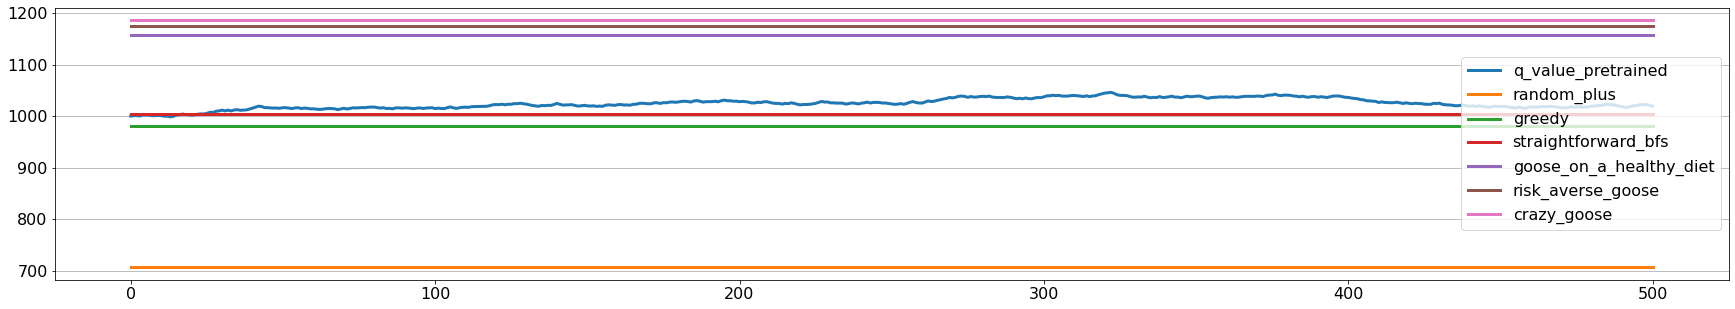

In [12]:
compute_elo_ranking(*ret, initial_agent_elo=1000, k=1)

In [13]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/13_q_value_pretrain_ranking_reward_boilergoose/04_ranking_reward_-2_3_10000episodes_epsilon001/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=20)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/13_q_value_pretrain_ranking_reward_boilergoose/04_ranking_reward_-2_3_10000episodes_epsilon001/q_value_agent.py
Goose Collision: SOUTH
Goose Collision: WEST
Goose Collision: WEST
Goose Collision: EAST


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1055
straightforward_bfs,1004
greedy,981
random_plus,706


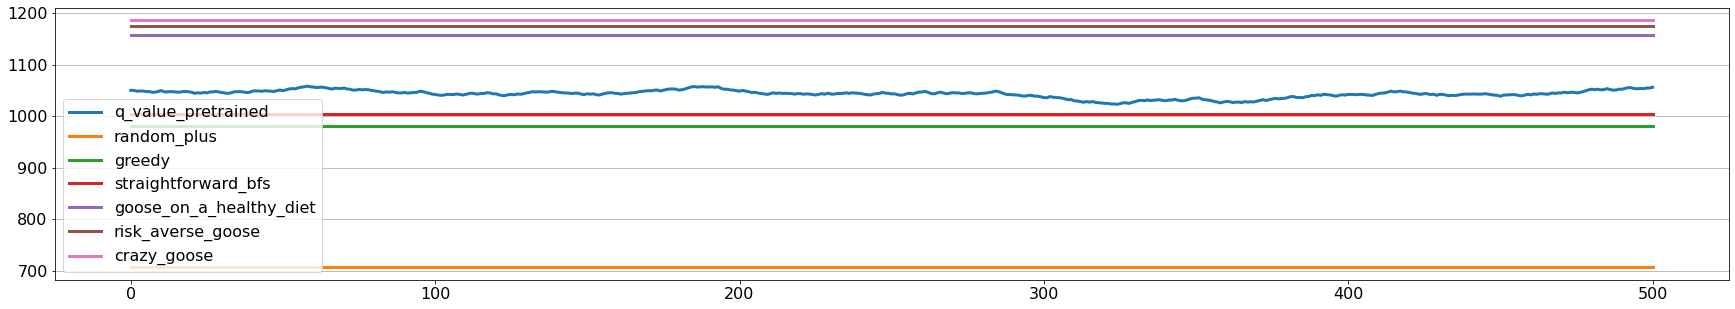

In [15]:
compute_elo_ranking(*ret, initial_agent_elo=1050, k=1)

I need to solve the problem of improving a policy. I could try using different agents, ones with epsilon and others without.

### Combine greedy and non greedy players

#### Generation

In [11]:
n_matches = 2000
name = 'boilergoose_combo1'
agents = [
    '/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_boilergoose_002.py',
    '/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_boilergoose_001.py',
    '/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/boilergoose.py',
    '/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/boilergoose.py',
]   
reward_name = 'ranking_reward_-2_3'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, name, n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18); gc.collect()

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_boilergoose_002.py
Goose Collision: SOUTH


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Size of the boards is 5.9 GB


0

In [12]:
n_matches = 10000
name = 'boilergoose_combo1'
agents = [
    '/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_boilergoose_002.py',
    '/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_boilergoose_001.py',
    '/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/boilergoose.py',
    '/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/boilergoose.py',
]   
reward_name = 'ranking_reward_-2_3'
output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_matches_%i.npz' % (reward_name, name, n_matches)
create_train_data(agents=agents, n_matches=n_matches, output_file=output_file, reward_name=reward_name, max_workers=18); gc.collect()

Testing agent: /mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_boilergoose_002.py
Goose Collision: SOUTH
Goose Collision: NORTH


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Size of the boards is 29.3 GB


0

#### Evaluation

In [11]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/13_q_value_pretrain_ranking_reward_boilergoose/05_ranking_reward_-2_3_10000episodes_combo1/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=20)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/13_q_value_pretrain_ranking_reward_boilergoose/05_ranking_reward_-2_3_10000episodes_combo1/q_value_agent.py
Goose Collision: NORTH
Goose Collision: WEST
Goose Collision: NORTH


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
straightforward_bfs,1004
greedy,981
q_value_pretrained,890
random_plus,706


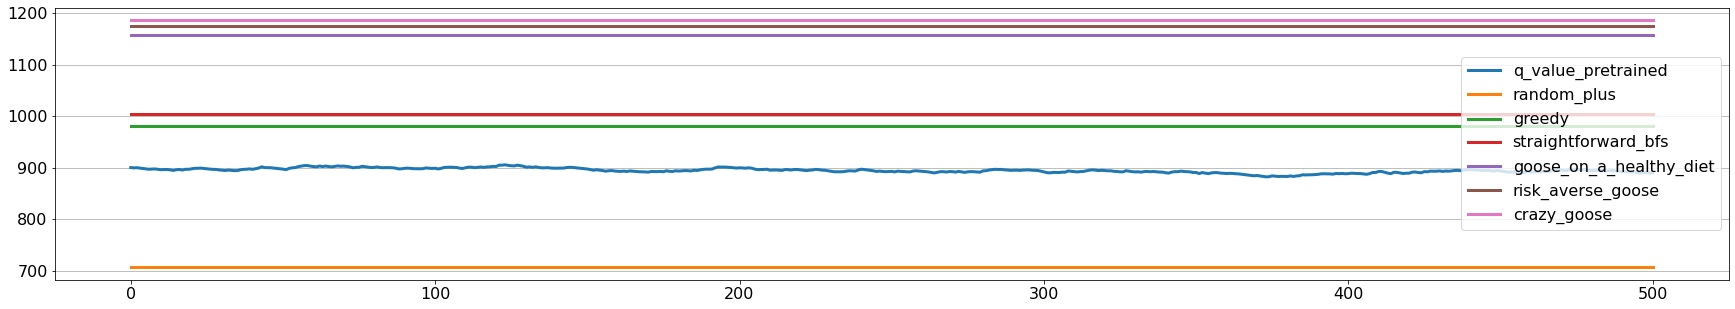

In [13]:
compute_elo_ranking(*ret, initial_agent_elo=900, k=1)

Very bad result, I'm struggling to learn a Q value function from the boilergoose that is able to outperform the model.

#### Bigger models

In [23]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/13_q_value_pretrain_ranking_reward_boilergoose/06_ranking_reward_-2_3_10000episodes_combo1_x32/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=20)

Testing agent: /mnt/hdd0/Kaggle/hungry_geese/models/13_q_value_pretrain_ranking_reward_boilergoose/06_ranking_reward_-2_3_10000episodes_combo1_x32/q_value_agent.py
Goose Collision: NORTH
Goose Collision: SOUTH
Goose Collision: SOUTH
Goose Collision: WEST


  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1014
straightforward_bfs,1004
greedy,981
random_plus,706


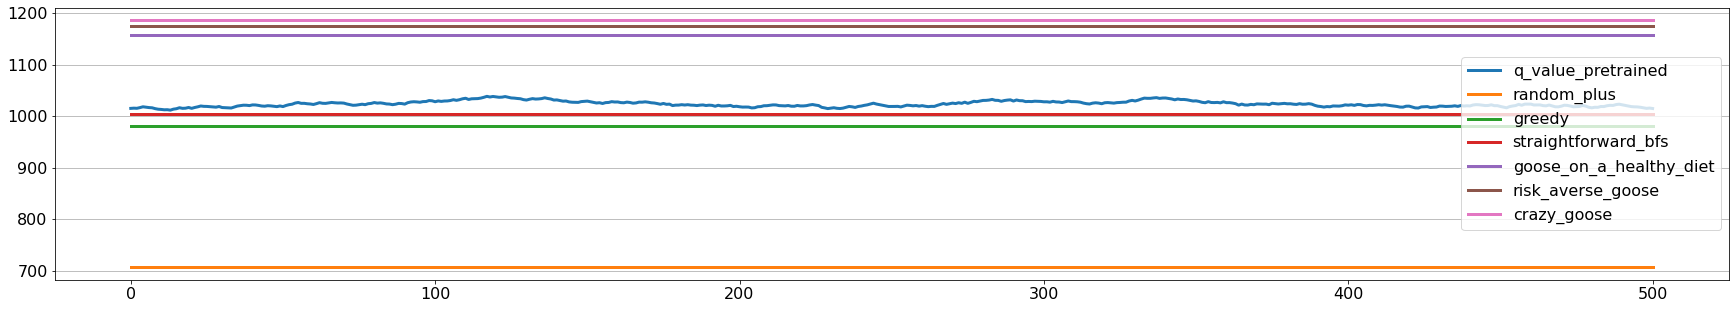

In [26]:
compute_elo_ranking(*ret, initial_agent_elo=1015, k=1)

In [13]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/13_q_value_pretrain_ranking_reward_boilergoose/07_ranking_reward_-2_3_10000episodes_combo1_x64/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=20)

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1007
straightforward_bfs,1004
greedy,981
random_plus,706


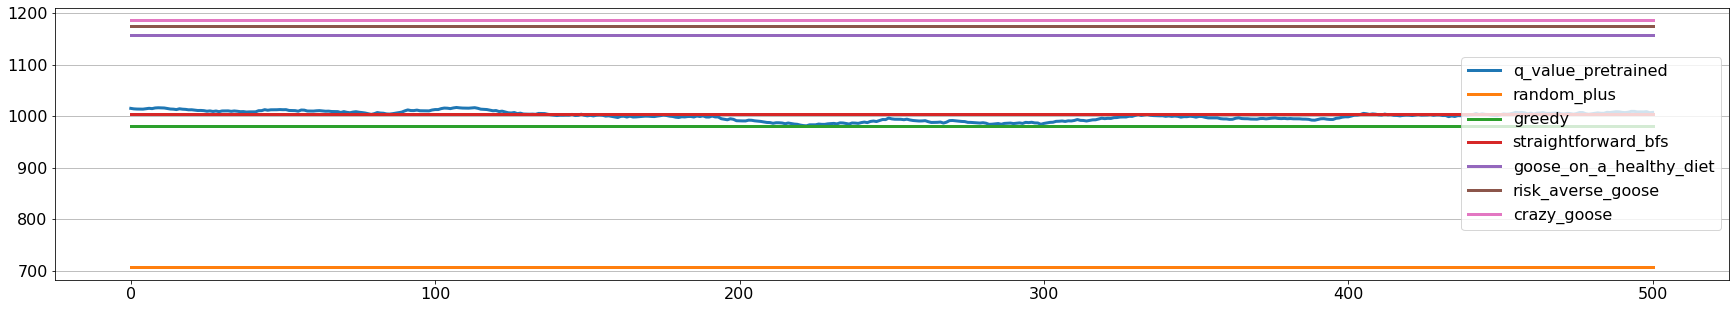

In [14]:
compute_elo_ranking(*ret, initial_agent_elo=1015, k=1)

In [15]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/13_q_value_pretrain_ranking_reward_boilergoose/07_ranking_reward_-2_3_10000episodes_combo1_x64/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=True, max_workers=20)

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1026
straightforward_bfs,1004
greedy,981
random_plus,706


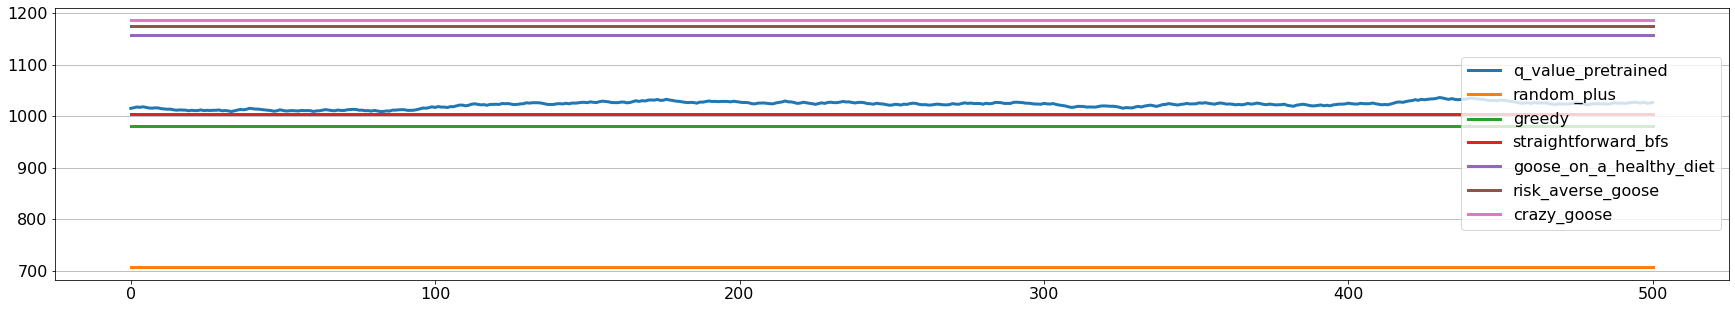

In [16]:
compute_elo_ranking(*ret, initial_agent_elo=1015, k=1)

In [17]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/13_q_value_pretrain_ranking_reward_boilergoose/08_ranking_reward_-2_3_10000episodes_combo1_x128/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=20)

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1026
straightforward_bfs,1004
greedy,981
random_plus,706


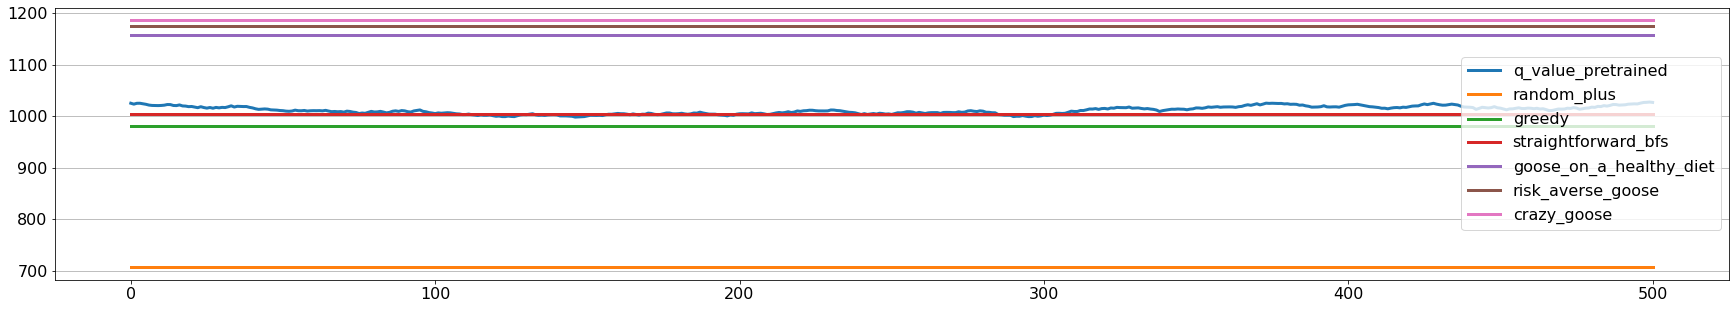

In [19]:
compute_elo_ranking(*ret, initial_agent_elo=1025, k=1)

## Summary